# Resonator Spectroscopy with SHFQA or SHFQC

This notebook shows you how to perform CW resonator spectroscopy in LabOne Q with a SHFQA or the quantum analyzer channels of a SHFQC. Here, you'll find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line.

A demonstration of this notebook, starting from the basics of installing LabOne Q, is also available on our Youtube channel [here](https://www.youtube.com/watch?v=aRaGHNZeVkI&list=PLjxUCNDRYw8k1_HTzXDohUHKhYKYFQrbn&index=1&ab_channel=ZurichInstruments)

## 0. LabOne Q Imports

You'll begin by importing `laboneq.simple` and some extra helper functions to run the examples. 

In [1]:
# LabOne Q:
from laboneq.simple import *

# Helpers:
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_results
from laboneq.contrib.example_helpers.generate_example_datastore import (
    generate_example_datastore,
    get_first_named_entry,
)

from pathlib import Path
import time

In [2]:
# Build an in-memory data store with device setup and qubit parameters for the
# example notebooks
setup_db = generate_example_datastore(in_memory=True)

## 1. Device Setup

Below, you'll create a device setup and specify to run in an emulated mode or on hardware, `emulate = True/False` respectively.

If you run on your hardware, the [descriptor](https://docs.zhinst.com/labone_q_user_manual/concepts/set_up_equipment/) called by `create_device_setup` should be replaced by one of your own, generally stored as a [YAML file](https://docs.zhinst.com/labone_q_user_manual/concepts/set_up_equipment#labone_q.func_concepts.setting_up.set_up_equipment.descriptor). Once you have this descriptor, it can be reused for all your experiments.

In [3]:
# load a calibrated device setup from the dummy database
device_setup = get_first_named_entry(
    db=setup_db, name="6_qubit_setup_shfsg_shfqa_hdawg_pqsc_calibrated"
)

emulate = True

\\home\home\sam68451\LabOneQ Software Local Samuel\laboneq\laboneq\dsl\calibration\oscillator.py:58: FutureWarning: `Oscillator` argument `carrier_type` will be removed in the future versions. It has no functionality.
  warnings.warn(


In [4]:
# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2023.10.09 11:06:37.084] INFO    Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\laboneq_output\log
[2023.10.09 11:06:37.096] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:06:37.100] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:06:37.103] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:06:37.117] INFO    Configuring the device setup
[2023.10.09 11:06:37.186] INFO    The device setup is configured


## 2. Experiment Parameters

Now you'll define the frequency sweep parameters to use in your experiment.

In [5]:
# frequency range of spectroscopy scan - around expected centre frequency as defined in qubit parameters
start_freq = -200.0e6
stop_freq = 200.0e6
num_points = 101
integration_time = 1e-3

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 4


# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"{qubit}_res_freq",
        start=start_freq,
        stop=stop_freq,
        count=num_points,
        axis_name="Frequency [Hz]",
    )

## 3. Experiment Definition

You'll now create a function which generates you CW spectroscopy [experiment](https://docs.zhinst.com/labone_q_user_manual/concepts/experiment/). In this experiment, you'll pass the `LinearSweepParameter` defined previously as an argument to the [sweep section](https://docs.zhinst.com/labone_q_user_manual/concepts/averaging_sweeping/#labone_q.func_concepts.experiment.averaging_sweeping.parameters_sweeps). Within the section, you'll create a [section](https://docs.zhinst.com/labone_q_user_manual/concepts/sections_and_pulses/) containing an `acquire` command.

In [6]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=pow(2, exp_settings["num_averages"]),
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")
                exp_spec.reserve(signal="acquire")

    return exp_spec

### 3.1 Experiment Calibration and Signal Map

Before running the experiment, you'll need to set an [experiment calibration](https://docs.zhinst.com/labone_q_user_manual/concepts/experiment_calibration/). The sweep parameter is assigned to the hardware oscillator modulating the readout resonator drive line. You'll also define and set the mapping between the experimental and logical lines.

In [7]:
# function that returns the calibration of the readout line oscillator for the experimental signals
def res_spec_calib(freq_sweep):
    exp_calibration = Calibration()
    # sets the oscillator of the experimental measure signal
    exp_calibration["measure"] = SignalCalibration(
        # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
        oscillator=Oscillator(
            "readout_osc",
            frequency=freq_sweep,
            modulation_type=ModulationType.HARDWARE,
        )
    )
    return exp_calibration


# signal maps for the two different qubits - maps the logical signal of the device setup to the experimental signals of the experiment


def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map


# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep("q0", start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment to qubit 0
exp_spec.set_calibration(res_spec_calib(freq_sweep))
exp_spec.set_signal_map(res_spec_map("q0"))

### 3.2 Compile and Generate Pulse Sheet

Now you'll compile the experiment and generate a pulse sheet.

In [8]:
# compile the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Resonator_Spectroscopy_Pulse_Sheet", compiled_res_spec)

[2023.10.09 11:06:37.443] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:06:37.445] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:06:37.447] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:06:37.469] INFO    Configuring the device setup
[2023.10.09 11:06:37.703] INFO    The device setup is configured
[2023.10.09 11:06:37.712] INFO    Starting LabOne Q Compiler run...
[2023.10.09 11:06:37.737] INFO    Schedule completed
[2023.10.09 11:06:37.797] INFO     ──────────────────────────────────────────────────────────────────── 
[2023.10.09 11:06:37.799] INFO      Device           AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2023.10.09 11:06:37.801] INFO     ──────────────────────────────────────────────────────────────────── 
[2023.10.09 11:06:37.804] INFO      SHFQA_dev12002     0         27            0           0         0  
[2023.10.09 11:06:37.813] INFO     ───────────────────────────────────────────

u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\Pulse_Sheets\Resonator_Spectroscopy_Pulse_Sheet_2023-10-09-11-06-37.html

### 3.3 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [9]:
# run the compiled experiemnt
res_spec_results = session.run(compiled_res_spec)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/{timestamp}_results.json")
print(f"File saved as Results/{timestamp}_results.json")

[2023.10.09 11:06:38.398] INFO    Starting near-time execution...
[2023.10.09 11:06:38.518] INFO    Finished near-time execution.
File saved as Results/20231009T110638_results.json


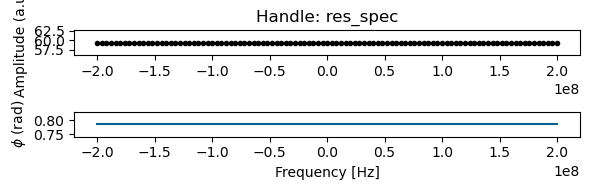

In [10]:
# plot the results
plot_results(res_spec_results, phase=True)